# Using Weak Supervision to Generate Book Recommendations

### by Vinayak Siva Kumar

We will use a books dataset to collect several user ratings and generate ratings of the books based on book ids that the users have interacted with, using weak supervision.

## Loading Books Dataset

Dataset credit to Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18.  &
Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19.

We have a set of users and books, and for each user we know the set of books they have interacted with (read or marked as to-read). We don't have the user's numerical ratings for the books they read, except in a small number of cases. We also have some text reviews written by users.

This recommendation engine would be able to recommend books to a user when they visit the site that visits this site. For example, we can just predict the rating for the user paired with a book for a few thousand likely books, then pick the books with the top ten predicted ratings.

In [4]:
from data import download_and_process_data

(df_train, df_test, df_dev, df_valid), df_books = download_and_process_data()

df_books.head()

C:\Users\Vinay\Documents\Weakly Supervision\data.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interactions_nz["rating_4_5"] = df_interactions_nz.rating.map(ratings_map)


,authors,average_rating,book_id,country_code,description,is_ebook,language_code,ratings_count,similar_books,text_reviews_count,title,first_author,book_idx
3,[293603],4.35,10099492,US,It all comes down to this.\nVlad's running out...,True,eng,152,"[25861113, 7430195, 18765937, 6120544, 3247550...",9,Twelfth Grade Kills (The Chronicles of Vladimi...,293603,0
4,[4018722],3.71,22642971,US,The future world is at peace.\nElla Shepherd h...,True,eng,1525,"[20499652, 17934493, 13518102, 16210411, 17149...",428,The Body Electric,4018722,1
5,[6537142],3.89,31556136,US,A gorgeously written and deeply felt literary ...,True,,109,[],45,Like Water,6537142,2
12,"[6455200, 5227552]",3.90,18522274,US,Zoe Vanderveen is on the run with her captor t...,True,en-US,191,"[25063023, 18553080, 17567752, 18126509, 17997...",6,"Volition (The Perception Trilogy, #2)",6455200,3
13,[187837],3.19,17262776,US,"The war is over, but for thirteen-year-old Rac...",True,eng,248,"[16153997, 10836616, 17262238, 16074827, 13628...",68,Little Red Lies,187837,4


Important Features we will extract/make:
- user_idx: A unique identifier for a user.
- book_idx: A unique identifier for a book that is being rated by the user.
- book_idxs: The set of books that the user has interacted with (read or planned to read).
- review_text: Optional text review written by the user for the book.
- rating: Either 0 (which means the user did not read or did not like the book) or 1 (which means the user read and liked the book). The rating field is missing for df_train. We will be generating this "weak" label 

## Creating Weak Labels

If a user has interacted with several books written by an author, there is a good chance that the user will read and like other books by the same author. We express this as a labeling function, using the first_author field in the df_books dataframe. We use 15 books as a treshold for this though. We also  write a simple LF that looks for similar phrases to guess the user's rating of a book. We interpret >= 4 stars to indicate a positive rating, while < 4 stars is negative.

In [5]:
#Labels to occupy the ratings column
POSTIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
from snorkel.labeling.lf import labeling_function

book_to_first_author = dict(zip(df_books.book_idx, df_books.first_author))
first_author_to_books_df = df_books.groupby("first_author")[["book_idx"]].agg(set)
first_author_to_books = dict(
    zip(first_author_to_books_df.index, first_author_to_books_df.book_idx)
)


@labeling_function(
    resources=dict(
        book_to_first_author=book_to_first_author,
        first_author_to_books=first_author_to_books,
    )
)
def shared_first_author(x, book_to_first_author, first_author_to_books):
    author = book_to_first_author[x.book_idx]
    same_author_books = first_author_to_books[author]
    num_read = len(set(x.book_idxs).intersection(same_author_books))
    return POSITIVE if num_read > 15 else ABSTAIN

In [55]:
low_rating_strs = [
    "one star",
    "1 star",
    "two star",
    "2 star",
    "3 star",
    "three star",
    "3.5 star",
    "2.5 star",
    "1 out of 5",
    "2 out of 5",
    "3 out of 5",
]
high_rating_strs = ["5 stars", "five stars", "four stars", "4 stars", "4.5 stars"]


@labeling_function(
    resources=dict(low_rating_strs=low_rating_strs, high_rating_strs=high_rating_strs)
)
def stars_in_review(x, low_rating_strs, high_rating_strs):
    if not isinstance(x.review_text, str):
        return ABSTAIN
    for low_rating_str in low_rating_strs:
        if low_rating_str in x.review_text.lower():
            return NEGATIVE
    for high_rating_str in high_rating_strs:
        if high_rating_str in x.review_text.lower():
            return POSITIVE
    return ABSTAIN

In [9]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_polarity(x):
    if isinstance(x.review_text, str):
        x.blob = TextBlob(x.review_text)
    else:
        x.blob = None
    return x


# Label high polarity reviews as positive.
@labeling_function(pre=[textblob_polarity])
def polarity_positive(x):
    if x.blob:
        if x.blob.polarity > 0.3:
            return POSITIVE
    return ABSTAIN


# Label high subjectivity reviews as positive.
@labeling_function(pre=[textblob_polarity])
def subjectivity_positive(x):
    if x.blob:
        if x.blob.subjectivity > 0.75:
            return POSITIVE
    return ABSTAIN


# Label low polarity reviews as negative.
@labeling_function(pre=[textblob_polarity])
def polarity_negative(x):
    if x.blob:
        if x.blob.polarity < 0.0:
            return NEGATIVE
    return ABSTAIN

C:\ProgramData\Anaconda3\envs\snorkel\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\ProgramData\Anaconda3\envs\snorkel\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and

We run TextBlob, a tool that provides a pretrained sentiment analyzer, on the reviews, and use its polarity and subjectivity scores to estimate the user's rating for the book. 

In [10]:
from snorkel.labeling import PandasLFApplier, LFAnalysis

lfs = [
    stars_in_review,
    shared_first_author,
    polarity_positive,
    subjectivity_positive,
    polarity_negative,
]

applier = PandasLFApplier(lfs)
L_dev = applier.apply(df_dev)

100%|██████████| 8267/8267 [00:04<00:00, 1655.49it/s]


## Attach the pseudo-labels to the model

In [12]:
from snorkel.labeling.model import LabelModel

L_train = applier.apply(df_train)
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=5000, seed=123, log_freq=20, lr=0.01)
preds_train = label_model.predict(L_train)

100%|██████████| 795540/795540 [08:01<00:00, 1653.15it/s]


In [13]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, preds_train_filtered = filter_unlabeled_dataframe(
    df_train, preds_train, L_train
)
df_train_filtered["rating"] = preds_train_filtered

C:\ProgramData\Anaconda3\envs\snorkel\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Designing The Neural Network Prediction Model

We write a Tensorflow-Keras model for predicting ratings given a user's book list and a book (which is being rated). The model represents the list of books the user interacted with, books_idxs, by learning an embedding for each idx, and averaging the embeddings in book_idxs. It learns another embedding for the book_idx, the book to be rated. Then it concatenates the two embeddings and uses an MLP network to compute the probability of the rating being 1

In [81]:
import numpy as np
import tensorflow as tf
from data import precision_batch, recall_batch, f1_batch

n_books = max([max(df.book_idx) for df in [df_train, df_test, df_dev, df_valid]])


# Keras model to predict rating given book_idxs and book_idx.
def get_model(embed_dim=64, hidden_layer_sizes=[32]):
    # Compute embedding for book_idxs.
    len_book_idxs = tf.keras.layers.Input([])
    book_idxs = tf.keras.layers.Input([None])
    # book_idxs % n_books is to prevent crashing if a book_idx in book_idxs is > n_books.
    book_idxs_emb = tf.keras.layers.Embedding(n_books, embed_dim)(book_idxs % n_books)
    book_idxs_emb = tf.math.divide(
        tf.keras.backend.sum(book_idxs_emb, axis=1), tf.expand_dims(len_book_idxs, 1)
    )
    # Compute embedding for book_idx.
    book_idx = tf.keras.layers.Input([])
    book_idx_emb = tf.keras.layers.Embedding(n_books, embed_dim)(book_idx)
    input_layer = tf.keras.layers.concatenate([book_idxs_emb, book_idx_emb], 1)
    # Build MLP on input layer.
    cur_layer = input_layer
    for size in hidden_layer_sizes:
        tf.keras.layers.Dense(size, activation=tf.nn.relu)(cur_layer)
    output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(cur_layer)
    # Create and compile keras model.
    model = tf.keras.Model(
        inputs=[len_book_idxs, book_idxs, book_idx], outputs=[output_layer]
    )
    model.compile(
        "Adagrad",
        "binary_crossentropy",
        metrics=["accuracy", precision_batch, recall_batch,ndcg_score],
    )
    return model

In [42]:
# Generator to turn dataframe into data points.
def get_data_points_generator(df):
    def generator():
        for book_idxs, book_idx, rating in zip(df.book_idxs, df.book_idx, df.rating):
            # Remove book_idx from book_idxs so the model can't just look it up.
            book_idxs = tuple(filter(lambda x: x != book_idx, book_idxs))
            yield {
                "len_book_idxs": len(book_idxs),
                "book_idxs": book_idxs,
                "book_idx": book_idx,
                "label": rating,
            }
            if rating == 1:
                # Generate a random negative book_id not in book_idxs.
                random_negative = np.random.randint(0, n_books)
                while random_negative in book_idxs:
                    random_negative = np.random.randint(0, n_books)
                yield {
                    "len_book_idxs": len(book_idxs),
                    "book_idxs": book_idxs,
                    "book_idx": random_negative,
                    "label": 0,
                }

    return generator


def get_data_tensors(df):
    # Use generator to get data points each epoch, along with shuffling and batching.
    padded_shapes = {
        "len_book_idxs": [],
        "book_idxs": [None],
        "book_idx": [],
        "label": [],
    }
    dataset = (
        tf.data.Dataset.from_generator(
            get_data_points_generator(df), {k: tf.int64 for k in padded_shapes}
        )
        .shuffle(123)
        .repeat(None)
        .padded_batch(batch_size=256, padded_shapes=padded_shapes)
    )
    tensor_dict = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()
    return (
        (
            tensor_dict["len_book_idxs"],
            tensor_dict["book_idxs"],
            tensor_dict["book_idx"],
        ),
        tensor_dict["label"],
    )

## Training The Model

In [69]:
from data import get_n_epochs
import matplotlib.pyplot as plt


model = get_model()

X_train, Y_train = get_data_tensors(df_train_filtered)
X_valid, Y_valid = get_data_tensors(df_valid)
train_model=model.fit(
    X_train,
    Y_train,
    steps_per_epoch=300,
    validation_data=(X_valid, Y_valid),
    validation_steps=20,
    epochs=get_n_epochs(),
    verbose=1,
)



Epoch 1/30
300/300 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.5033 - precision_batch: 0.2933 - recall_batch: 0.2933 - val_loss: 0.6914 - val_accuracy: 0.5742 - val_precision_batch: 0.4982 - val_recall_batch: 0.5246
Epoch 2/30
300/300 [==============================] - 0s 781us/step - loss: 0.6912 - accuracy: 0.5500 - precision_batch: 0.1833 - recall_batch: 0.1833 - val_loss: 0.6913 - val_accuracy: 0.5781 - val_precision_batch: 0.4995 - val_recall_batch: 0.5091
Epoch 3/30
300/300 [==============================] - 0s 704us/step - loss: 0.6895 - accuracy: 0.6300 - precision_batch: 0.2233 - recall_batch: 0.2233 - val_loss: 0.6913 - val_accuracy: 0.5781 - val_precision_batch: 0.4995 - val_recall_batch: 0.5091
Epoch 4/30
300/300 [==============================] - 0s 708us/step - loss: 0.6897 - accuracy: 0.5900 - precision_batch: 0.1800 - recall_batch: 0.1800 - val_loss: 0.6912 - val_accuracy: 0.5742 - val_precision_batch: 0.4981 - val_recall_batch: 0.5036
Ep

300/300 [==============================] - 0s 528us/step - loss: 0.6724 - accuracy: 0.7278 - precision_batch: 0.1667 - recall_batch: 0.1667 - val_loss: 0.6905 - val_accuracy: 0.5859 - val_precision_batch: 0.5613 - val_recall_batch: 0.3642


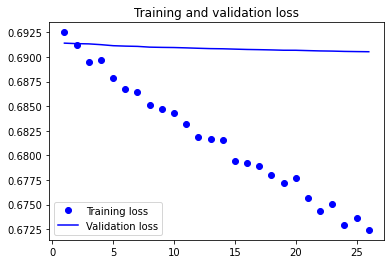

In [70]:
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Testing the Model

In [72]:
X_test, Y_test = get_data_tensors(df_test)
test_results = model.evaluate(X_test, Y_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.6484 - precision_batch: 0.3006 - recall_batch: 0.1889


In [82]:
print("Accuracy is ",round(test_results[1],4))
print("Precision Score is ",round(test_results[2],4))
print("Recall Score is ",round(test_results[3],4))

Accuracy is  0.6484
Precision Score is  0.3006
Recall Score is  0.1889
